## Throughput Graph

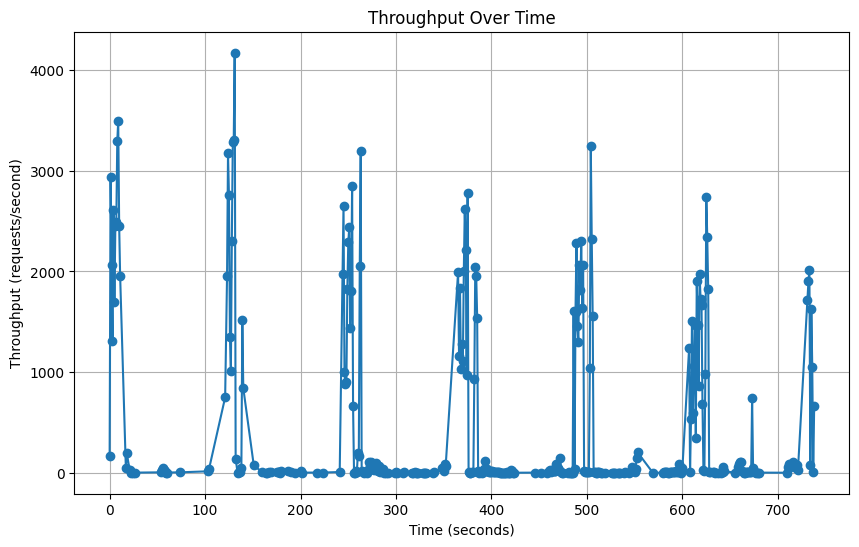

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

# Get all CSV files starting with "response time" in the current folder
csv_files = glob.glob('response_time*.csv')

# Initialize an empty list to hold all the data
all_data = []

# Load each CSV file and append the data to the list
for csv_file in csv_files:
    data = pd.read_csv(csv_file)
    all_data.append(data)

# Check if there are any CSV files to concatenate
if all_data:
    # Concatenate all data into a single DataFrame
    all_data = pd.concat(all_data, ignore_index=True)

    # Convert start_time from milliseconds to seconds
    all_data['start_time'] = all_data['start_time'] // 1000

    # Calculate the throughput per second
    throughput = all_data.groupby('start_time').size()

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(throughput.index - throughput.index.min(), throughput.values, marker='o')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Throughput (requests/second)')
    plt.title('Throughput Over Time')
    plt.grid(True)
    plt.show()
else:
    print("No CSV files found matching the pattern 'response time*.csv'")